In [1]:
import numpy as np
from pykalman import KalmanFilter

In [2]:
from utils import *

In [3]:
def get_projected_celerity_profiles2(PROFS, step):
    projected_profiles = []
    for prof in PROFS:
        domain = np.arange(int(prof.depth[-1])+1, int(prof.depth[0]), step)
        p = prof.get_sound_speed(domain)
        projected_profiles.append(p)
    return projected_profiles

In [84]:
Im = 0.1
H = np.array([[1,0,0]])
std_mes = 2
std_dyn = 3
TM = np.array([[1, Im, Im**2/2],
        [0, 1, Im],
        [0, 0, 1]])
Q = std_dyn ** 2 * np.array([[Im ** 6 / 20, Im ** 5 / 8, Im ** 4 / 6],
                                       [Im ** 5 / 8, Im ** 4 / 3, Im ** 3 / 2],
                                       [Im ** 4 / 6, Im ** 3 / 2, Im ** 2]])

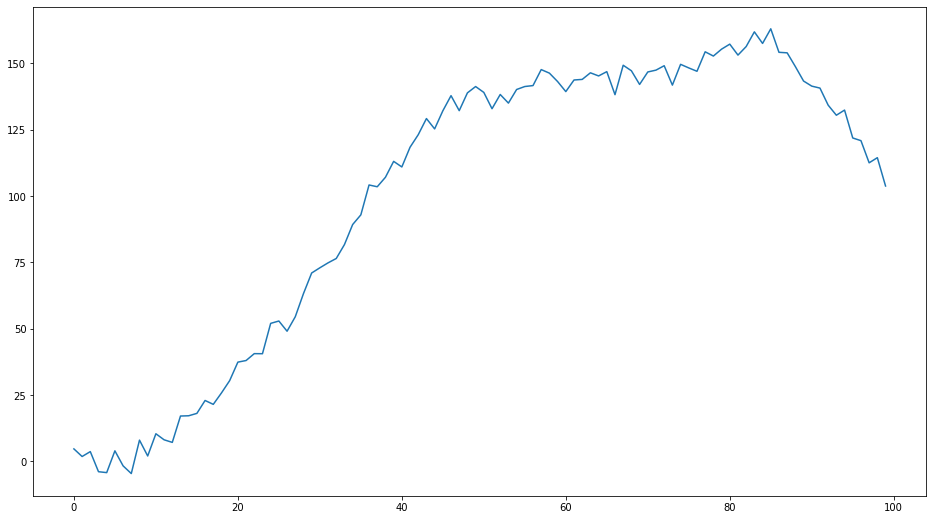

In [85]:
def generate_synthetic_data(K):
    X_true = np.zeros((3, K))
    Y = np.zeros(K)
    x_true = np.array([[1], [1], [1]])
    X_true[:, 0] = x_true.T
    Y[0] = H.dot(x_true) + np.random.normal(0, std_mes, 1)
    for k in range(1, K):
        x_true = TM.dot(X_true[:, k-1]) + np.random.normal(0, std_dyn, 3)
        X_true[:, k] = x_true.T
        Y[k] = H.dot(x_true) + np.random.normal(0, std_mes, 1)
    return X_true, Y


X_true, Y = generate_synthetic_data(100)
plt.plot(Y)  
plt.show()

In [129]:
def plot_results(y, xs, ps, x_true=None, titl='Results of the Kalman smoother on synthetic data'):
    %pylab inline
    %matplotlib inline
    K = len(y)
    print(K)
    pylab.rcParams['figure.figsize'] = (16, 9)
    figure()
    line1,=plot(range(K),xs,'b',linewidth=2)
    line2,=plot(range(K),y,'.k')
    if x_true is not None:
        line3,=plot(range(K),x_true,'r',linewidth=2)
    fill_between(range(K), squeeze(xs) - 1.96 * sqrt(squeeze(ps)),
             squeeze(xs) + 1.96 * sqrt(squeeze(ps)), color='k', alpha=.2)
    lines = [line1, line2] if x_true is None else [line1, line2, line3]
    labels = ['Estimated state','Noisy observations $y$'] if x_true is None else ['Estimated state','Noisy observations $y$', 'True state $x$']
    legend(lines, labels, prop={'size': 20})
    ylim(min(y),max(y))
    title(titl, fontsize=20)


(100,)
Populating the interactive namespace from numpy and matplotlib
100


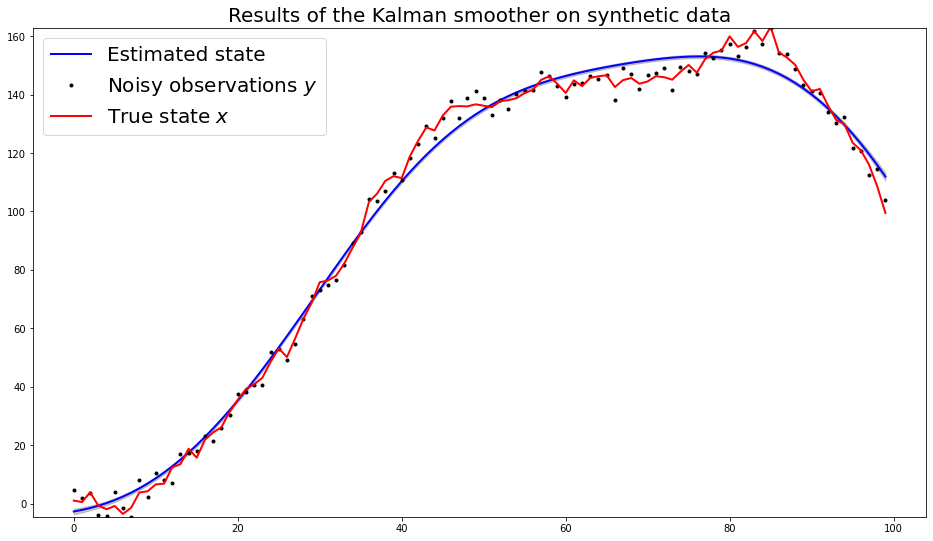

In [130]:

kf_test = KalmanFilter(transition_matrices = TM, observation_matrices = H,
                          
                         transition_covariance = Q, observation_covariance = [[std_mes]])
kf_test.em(Y, n_iter=5, em_vars=['observation_covariance, transition_covariance'])
xs, ps = kf_test.smooth(Y) #xs : state estimate, shape (N, 3), covariance of xs shape (N, 3, 3)
ps = ps[:, 0, 0] 
plot_results(Y, xs[:, 0], ps, X_true[0, :])


In [88]:
PROFS = get_all_profiles()
projected_PROFS = get_projected_celerity_profiles2(PROFS, Im)
print(f"The number of profiles that can be projected on the domain is {len(projected_PROFS)}.")
suppress_nans_celerities(projected_PROFS)
data = np.array([p.celerities for p in projected_PROFS])


The number of profiles that can be projected on the domain is 16730.


<ipython-input-88-4301614bbaf1>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  data = np.array([p.celerities for p in projected_PROFS])


In [91]:
kalman=KalmanFilter(transition_matrices = TM, observation_matrices = H,
                          
                         transition_covariance = Q, observation_covariance = [[std_mes]])



(390,)
Q estimates:  [[4.500e-07 1.125e-05 1.500e-04]
 [1.125e-05 3.000e-04 4.500e-03]
 [1.500e-04 4.500e-03 9.000e-02]]
R estimates:  [[2]]
Populating the interactive namespace from numpy and matplotlib
390


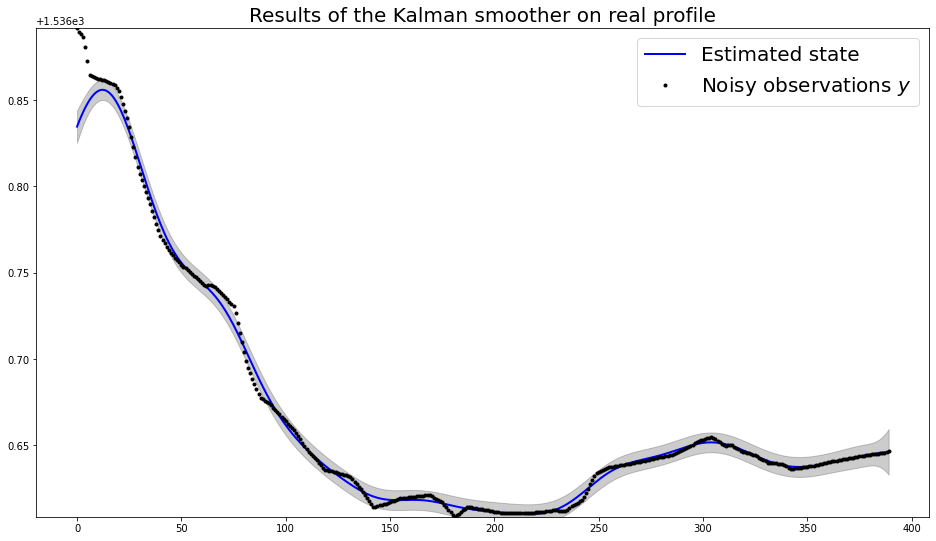

In [132]:
#kalman smoother on real profile
for i in range(1):
    plt.figure(figsize=(10, 2))
    y = projected_PROFS[i].celerities
    dom = projected_PROFS[i].domain
    y_avg = y-np.mean(y)
    print(y_avg.shape)
    #kalman.em(y_avg, n_iter=5, em_vars=['observation_covariance'])
    print('Q estimates: ', kalman.transition_covariance)
    print('R estimates: ', kalman.observation_covariance)
    xs, ps = kalman.smooth(y_avg)
    plot_results(y_avg + np.mean(y), xs[:, 0]+np.mean(y), ps[:, 0, 0]/10000, titl='Results of the Kalman smoother on real profile')
    
    

In [46]:
def detect_local_extrema(profile, domain):
    local_maxs = []
    local_mins = []
    previous_diff = profile[1] - profile[0]
    for i in range(1, len(profile)-1):
        diff = profile[i+1] - profile[i]
        if diff > 0 and previous_diff < 0:
            local_mins.append(domain[i])
        if diff < 0 and previous_diff > 0:
            local_maxs.append(domain[i])
        previous_diff = diff
    return local_mins, local_maxs

local_mins, local_maxs = detect_local_extrema(smoothed, domain)
print(local_mins)
print(local_maxs)
        
    
    
    

NameError: name 'domain' is not defined